In [1]:
from util import *
import pathlib
import os

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']
Connected DB CINS_SMY - conn


# CONSTANTS

In [2]:
feat_data_cols = [
    'CASA_HOLD','CARD_CREDIT_HOLD','EB_SACOMPAY_HOLD','EB_MBIB_HOLD',
    'LIFE_STG', 'AREA',
    'LOR','CREDIT_SCORE',
    'CASA_BAL_SUM_NOW','CASA_DAY_SINCE_LAST_TXN_CT_36M',
    'CARD_CREDIT_MAX_LIMIT','CARD_CREDIT_SUM_BAL_NOW',
    'EB_SACOMPAY_DAY_SINCE_LTST_LOGIN','EB_SACOMPAY_DAY_SINCE_LTST_TXN','EB_MBIB_DAY_SINCE_ACTIVE',
]

# REPO

In [3]:
REPO_LOC = pathlib.Path('./')
DATA_LOC = REPO_LOC / 'data'

# LOAD DATA

## GET ONLY ACTIVE CUSTOMER

In [4]:
# cust_status = download_or_reload('./data/01-07-2023/CUST_STATUS', "")

## LOAD ALL FEATURES AND LABEL

In [5]:
df = pd.read_pickle('./data/01-07-2023/MERGED_FEATURES')[['CUSTOMER_CDE', 'REACTIVATED'] + feat_data_cols]
print(len(df))

16593963


In [6]:
df = df[:5000000]

# PREPROCESS

## FORMAT DATA TYPE

In [7]:
df['REACTIVATED'] = df['REACTIVATED'].fillna(0)
df['REACTIVATED'] = df['REACTIVATED'].astype(int)

In [8]:
df['CASA_HOLD'] = pd.to_numeric(df['CASA_HOLD'],errors='coerce')
df['CARD_CREDIT_HOLD'] = pd.to_numeric(df['CARD_CREDIT_HOLD'],errors='coerce')
df['EB_SACOMPAY_HOLD'] = pd.to_numeric(df['EB_SACOMPAY_HOLD'],errors='coerce')
df['EB_MBIB_HOLD'] = pd.to_numeric(df['EB_MBIB_HOLD'],errors='coerce')

df['LOR'] = pd.to_numeric(df['LOR'],errors='coerce')
df['CREDIT_SCORE'] = pd.to_numeric(df['CREDIT_SCORE'],errors='coerce')

df['CASA_BAL_SUM_NOW'] = pd.to_numeric(df['CASA_BAL_SUM_NOW'],errors='coerce')
df['CASA_DAY_SINCE_LAST_TXN_CT_36M'] = pd.to_numeric(df['CASA_DAY_SINCE_LAST_TXN_CT_36M'],errors='coerce')

df['CARD_CREDIT_MAX_LIMIT'] = pd.to_numeric(df['CARD_CREDIT_MAX_LIMIT'],errors='coerce')
df['CARD_CREDIT_SUM_BAL_NOW'] = pd.to_numeric(df['CARD_CREDIT_SUM_BAL_NOW'],errors='coerce')

df['EB_SACOMPAY_DAY_SINCE_LTST_LOGIN'] = pd.to_numeric(df['EB_SACOMPAY_DAY_SINCE_LTST_LOGIN'],errors='coerce')
df['EB_SACOMPAY_DAY_SINCE_LTST_TXN'] = pd.to_numeric(df['EB_SACOMPAY_DAY_SINCE_LTST_TXN'],errors='coerce')
df['EB_MBIB_DAY_SINCE_ACTIVE'] = pd.to_numeric(df['EB_MBIB_DAY_SINCE_ACTIVE'],errors='coerce')

## WITH DATA FILTER CUSTOMER

In [9]:
for col in ['CASA_HOLD', 'CARD_CREDIT_HOLD', 'EB_SACOMPAY_HOLD', 'EB_MBIB_HOLD']:
    df[col].fillna(0, inplace=True)
    df[col] = df[col].astype(int)

# PREPROCESS

In [10]:
numfeat_cols = [
 'CASA_HOLD',
 'CARD_CREDIT_HOLD',
 'EB_SACOMPAY_HOLD',
 'EB_MBIB_HOLD',
 'LOR',
 'CREDIT_SCORE',
 'CASA_BAL_SUM_NOW',
 'CASA_DAY_SINCE_LAST_TXN_CT_36M',
 'CARD_CREDIT_MAX_LIMIT',
 'CARD_CREDIT_SUM_BAL_NOW',
 'EB_SACOMPAY_DAY_SINCE_LTST_LOGIN',
 'EB_SACOMPAY_DAY_SINCE_LTST_TXN',
 'EB_MBIB_DAY_SINCE_ACTIVE'
]

In [11]:
catfeat_cols = ['LIFE_STG', 'AREA']

In [12]:
preprocessor = pickle.load(open('preprocessor','rb'))

In [13]:
X, y = df[feat_data_cols], df['REACTIVATED']

In [14]:
X_tf = preprocessor.transform(X)

In [15]:
model = pickle.load(open('model','rb'))

In [16]:
y_pred = model.predict(X_tf)
y_prob = model.predict_proba(X_tf)

## P-R-AUC

In [17]:
p,r,f,_ = metrics.precision_recall_fscore_support(y, y_pred, average='binary')
auc = metrics.roc_auc_score(y, y_prob[:,1])
gini = 2 * auc - 1
p,r,f,auc, gini

(0.32006876674925416,
 0.3361121435777624,
 0.3278943278943278,
 0.9109551691359151,
 0.8219103382718302)

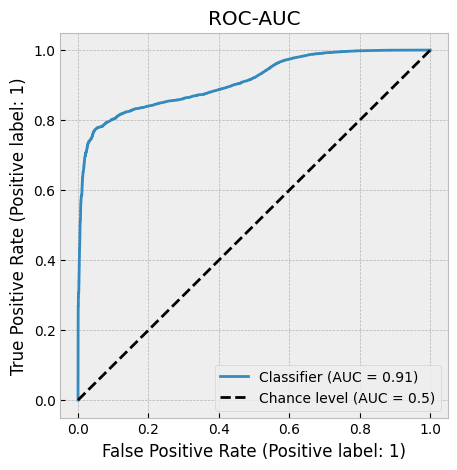

In [18]:
fig, axs = plt.subplots(1,1, figsize=(5, 5))
metrics.RocCurveDisplay.from_predictions(y, y_prob[:,1], plot_chance_level=True, ax=axs)
axs.set_title('ROC-AUC')
plt.show()

## P-R CURVE

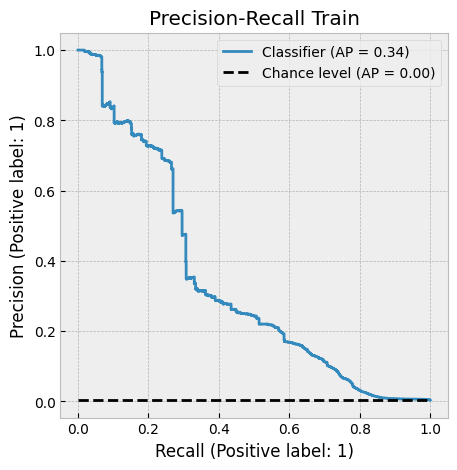

In [19]:
fig, axs = plt.subplots(1,1, figsize=(5, 5))
metrics.PrecisionRecallDisplay.from_predictions(y, y_prob[:,1], plot_chance_level=True, ax=axs)
axs.set_title('Precision-Recall Train')
axs.legend(loc='upper right')
plt.show()

In [20]:
def plot_precision_recall_with_thresholds(y_test, y_prob, ax):
    y_score = y_prob
    precisions, recalls, thresholds = metrics.precision_recall_curve(y_test, y_score)
    f1 = [2 * (p * r) / (p + r) for p, r in zip(precisions, recalls)]
    max_idx = np.argmax(f1)
    df = pd.DataFrame({
        'threshold': [0] + thresholds.tolist(),
        'precision': precisions,
        'recall': recalls,
        'f1-score': f1
    })
    # dfl = pd.melt(df, id_vars='threshold', value_vars=['precision', 'recall', 'f1-score'], var_name='metric', value_name='value')
    # ax = sns.lineplot(dfl, x='threshold', y='value',hue='metric')
    sns.lineplot(df.set_index('threshold'), palette='tab10', ax=ax, )
    ax.plot(thresholds[max_idx], f1[max_idx], marker='*', color='r', markersize=10)
    ax.text(thresholds[max_idx], f1[max_idx], f'({thresholds[max_idx]:.2f},{f1[max_idx]:.2f})', ha='left',va='top')

## P-R THRESHOLD

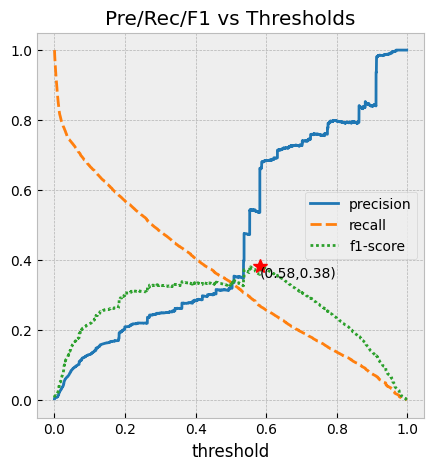

In [21]:
fig, axs = plt.subplots(1,1, figsize=(5, 5))
plot_precision_recall_with_thresholds(y, y_prob[:,1], ax=axs)
axs.set_title('Pre/Rec/F1 vs Thresholds')
plt.show()

## CLF REPORT

In [22]:
print(metrics.classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   4981167
           1       0.32      0.34      0.33     18833

    accuracy                           0.99   5000000
   macro avg       0.66      0.67      0.66   5000000
weighted avg       0.99      0.99      0.99   5000000

